In [1]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import HashingVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
import time
from wordcloud import WordCloud
import plotly.graph_objs as go
import re
import plotly.io as pio
from collections import Counter
print('imports done.')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dits\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


imports done.


## Data loading and pre-processing

In [2]:
movie_reviews_dataset = pd.read_json('../dataset_management/dataset_with_keyword_counts.json')

# Transpose dataset to put IDs as rows and have 5 columns instead.
movie_reviews_dataset = movie_reviews_dataset.T

movie_reviews_dataset.head()

,review,rating,label,positive_keywords,negative_keywords
167c69fa-1e1b-4715-be0e-85d651372029,"Lau Wing fights his way into Shaolin, apologiz...",3/10,Negative,41,18
3b99268c-46c3-483a-ae1f-a075ba183ca6,Every once in awhile you find a gem and you kn...,10/10,Positive,10,4
1ab96efe-6f5f-4608-bdff-dbafae9e530b,I was completely mesmerized by Lekin and espec...,9/10,Positive,39,12
5f011135-aee8-4f04-add2-dfffeebd94fb,Greatly enjoyed the development of the story l...,9/10,Positive,30,7
1a4efffa-3446-4fe5-9c43-a73411cdc45d,Yaara Sili Sili Virah Ki Raat Ka Jalna'Lekin' ...,8/10,Positive,57,20


In [3]:
movie_reviews_dataset['review'].iloc[0]

"Lau Wing fights his way into Shaolin, apologizing. Then he has a long talk with an old monk. Lee Wan Chung leads another group of monks outside. Lau Wing wants to learn kung fu for revenge. The old monk gives him a special sword then dies at will apparently. Lee and gang will not let him leave. The monks surround him in what they call an arhat formation. There is a fight so pathetically choreographed I cringed. He escapes by flying to the roof. Cut to the lovely Ting sisters fight a thief in a tea house. Cut to a fortune teller tells a swordsman about the sword. Cut back to our hero at a table with the sisters and everyone is discussing an important book.I always begin my reviews with a summary of the opening scenes. The reason for that is to make sure we are talking about the same movie. Many movies in this genre have more than one title and the titles typically have nothing to do with anything in the movie. This movie as an example has no jade hairpin at all. Though I have summarize

In [4]:
len(movie_reviews_dataset)

47947

In [4]:
# Check for NaN values and remove them
print("NaN (before cleanup) ?: \n", movie_reviews_dataset.isnull().sum())

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].fillna('')
movie_reviews_dataset['positive_keywords'] = movie_reviews_dataset['positive_keywords'].fillna(0)
movie_reviews_dataset['negative_keywords'] = movie_reviews_dataset['negative_keywords'].fillna(0)

print("NaN (after cleanup) ?: \n", movie_reviews_dataset.isnull().sum())

NaN (before cleanup) ?: 
 review                0
rating                0
label                 0
positive_keywords    21
negative_keywords    92
dtype: int64
NaN (after cleanup) ?: 
 review               0
rating               0
label                0
positive_keywords    0
negative_keywords    0
dtype: int64


In [5]:
# Text preprocessing for review column
# Lower all text

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=4,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].parallel_apply(remove_special_chars)

# get stopwords.
stop_words = set(stopwords.words('english'))

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]


movie_reviews_dataset['review'] = movie_reviews_dataset['review'].apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])


movie_reviews_dataset['review'] = movie_reviews_dataset['review'].apply(lemmatize_word)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].apply(remove_numbers)

print('Example of preprocessing train: ')
print(movie_reviews_dataset['review'].iloc[0])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Example of preprocessing train: 
lau wing fight way shaolin apologizing long talk old monk lee wan chung lead another group monk outside lau wing want learn kung fu revenge old monk give special sword dy apparently lee gang let leave monk surround call arhat formation fight pathetically choreographed cringed escape flying roof cut lovely ting sister fight thief tea house cut fortune teller tell swordsman sword cut back hero table sister everyone discussing important book always begin review summary opening scene reason make sure talking movie many movie genre one title title typically nothing anything movie movie example jade hairpin though summarized first  minute movie still idea going  minute mark chan sing give expository speech little late plot non existent least confusing part problem picture wide screen falsely stretched fill screen subtitle cut side plus subtitle solid white easily wash even accurately translated still missing one third spoken concerning action decide fight cho

## Visualizations

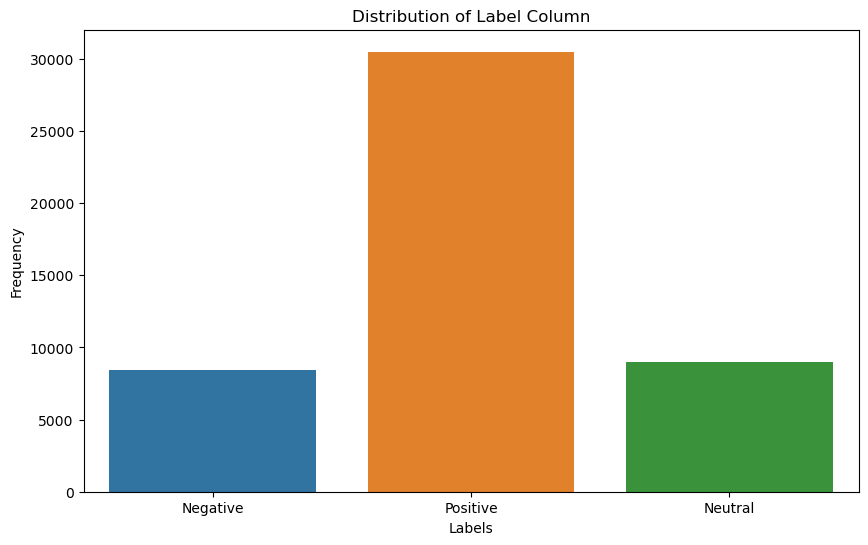

In [9]:
# Label distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(x=movie_reviews_dataset['label'], data=movie_reviews_dataset)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Label Column')
plt.show()

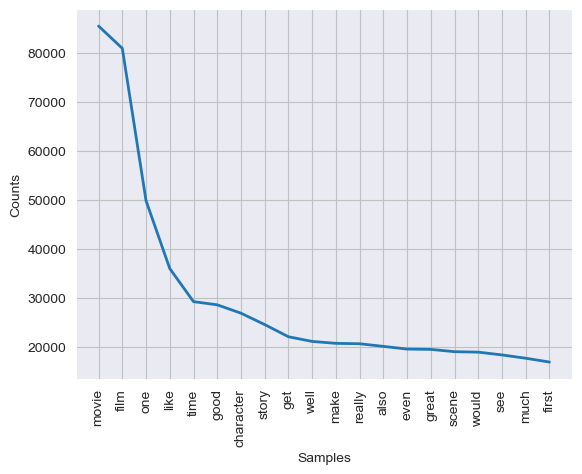

In [6]:
# Tokens frequency diagram
all_text = ' '.join(movie_reviews_dataset['review'])
tokens = word_tokenize(all_text)

sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

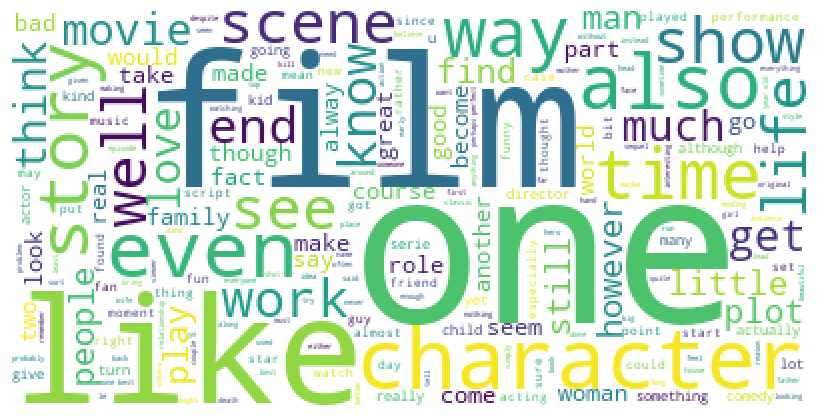

In [7]:
# Word cloud
all_text = ' '.join(tokens)
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(all_text)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

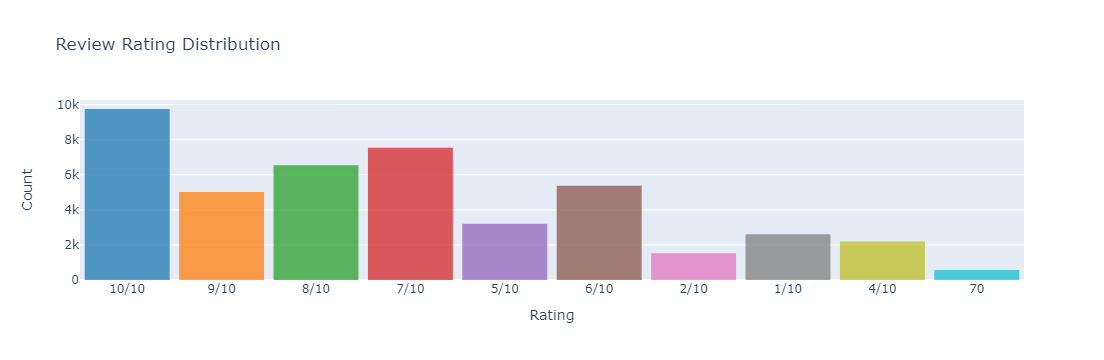

In [30]:
# Ratings variation
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

histogram_trace = go.Histogram(x=movie_reviews_dataset['rating'], 
                               xbins=dict(start=0.5, end=10.5, size=1),
                               marker=dict(color=colors),
                               opacity=0.75)

# Create the layout
layout = go.Layout(title='Review Rating Distribution',
                   xaxis=dict(
                    title='Rating'
                   ),
                   yaxis=dict(title='Count'),
                   bargap=0.1)

# Create the figure
fig = go.Figure(data=[histogram_trace], layout=layout)

# Display the figure
pio.show(fig)

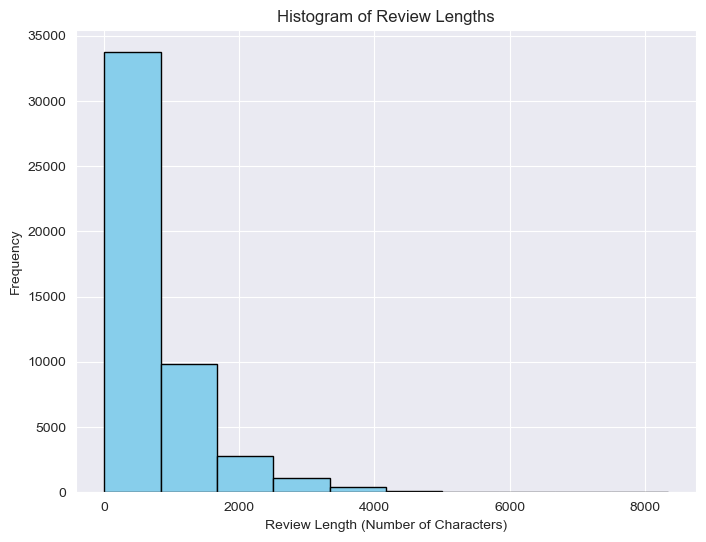

In [9]:
# Distribution of review lengths
# Calculate review lengths (number of characters)
review_lengths = [len(review) for review in movie_reviews_dataset['review']]

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(review_lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths')
plt.grid(True)
plt.show()